# Tutorial 4: Entanglement Forging with Qiskit Runtime and Quantum Serverless

In this tutorial, we apply Entanglement Forging to compute the energy of a $\mathrm{H}_2$ molecule using Qiskit Runtime. 

### Importing the relevant modules

In [1]:
from matplotlib import pyplot as plt
import numpy as np

from qiskit.circuit.library import TwoLocal
from qiskit.algorithms.optimizers import COBYLA
from qiskit.algorithms.optimizers.spsa import powerseries
from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import PySCFDriver
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.mappers.second_quantization import JordanWignerMapper
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.algorithms.ground_state_solvers import (
    GroundStateEigensolver,
    NumPyMinimumEigensolverFactory,
)
from qiskit_ibm_runtime import QiskitRuntimeService

from circuit_knitting_toolbox.entanglement_forging import (
    EntanglementForgingAnsatz,
    EntanglementForgingGroundStateSolver,
)

from quantum_serverless import QuantumServerless

### Set up the $\mathrm{H}_2$ molecule, specify the driver and converter, and instantiate the `ElectronicStructureProblem`

In [2]:
molecule = Molecule(
    geometry=[
        ("H", [0.0, 0.0, 0.0]),
        ("H", [0.0, 0.0, 0.735]),
    ],
    charge=0,
    multiplicity=1,
)
driver = PySCFDriver.from_molecule(molecule=molecule)
problem = ElectronicStructureProblem(driver)
converter = QubitConverter(JordanWignerMapper())

### Prepare the bitstrings and the ansatz

The ansatz for Entanglement Forging consists of a set of input bitstrings and a parameterized circuit. For this demo, we will use the same bitstrings and ansatz for both the U and V subsystems.

In [3]:
ansatz = EntanglementForgingAnsatz(
    circuit_u=TwoLocal(2, [], "cry", [[0, 1], [1, 0]], reps=1),
    bitstrings_u=[(1, 0), (0, 1)],
)

ansatz.circuit_u.draw()

┌──────────────────────┐
q_0: ┤0                     ├
     │  TwoLocal(θ[0],θ[1]) │
q_1: ┤1                     ├
     └──────────────────────┘

### Set up the QiskitRuntimeService object

In [4]:
# Use local versions of the primitives by default.
service = None

# Uncomment the following line to instead use Qiskit Runtime.
# service = QiskitRuntimeService()

### Declare which optimizer and backend(s) to use and finally instantiate the EntanglementForgingGroundStateSolver

In [5]:
optimizer = COBYLA(maxiter=20)

# Each backend will receive an even distribution of expvals to calculate at each iteration,
# and they will be run in parallel.
backend_names = ["<BACKEND_NAME0>", "<BACKEND_NAME1>"]

solver = EntanglementForgingGroundStateSolver(
    ansatz=ansatz,
    optimizer=optimizer,
    service=service,
    backend_names=backend_names,
)

### From within a Quantum Serverless context, run the solver to find the minimum eigenvalue
* We will run in the Quantum Serverless context so it can manage the distribution of algorithm functions to the hardware cluster
* The ansatz field must be set prior to calling solve
* If no optimizer is passed, SPSA with default settings will be used
* If the initial_point field is not set, it will be initialized to all 0's

In [6]:
%%capture

results = solver.solve(problem)

### Apply the energy shift and print the estimated ground state energy

In [7]:
print(
    f"Entanglement forging ground state energy: {results.groundenergy + results.energy_shift}"
)

Entanglement forging ground state energy: -1.1185141406150305


### We can also extract the results at each iteration of the classical optimizer.  

Energy:


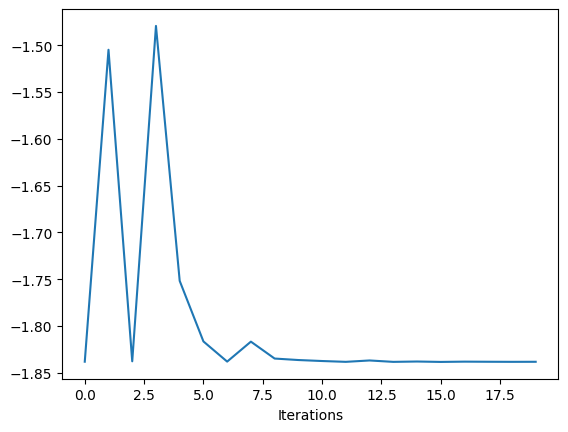

Schmidt Coefficients:


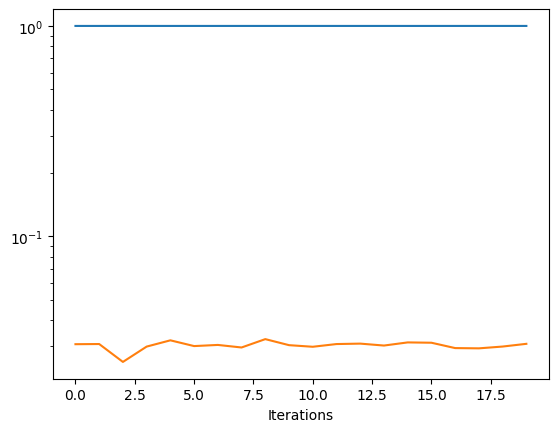

Parameters:


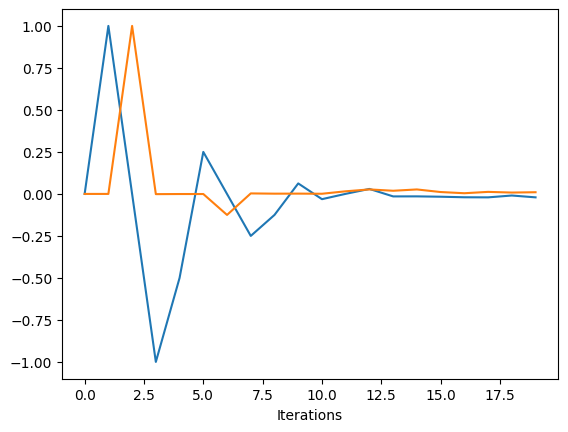

In [8]:
print("Energy:")
plt.plot([evaluation.eigenvalue for evaluation in results.history])
plt.xlabel("Iterations")
plt.show()

print("Schmidt Coefficients:")
plt.plot([abs(evaluation.eigenstate) for evaluation in results.history])
plt.xlabel("Iterations")
plt.yscale("log")
plt.show()

print("Parameters:")
plt.plot([evaluation.parameters for evaluation in results.history])
plt.xlabel("Iterations")
plt.show()

In [9]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright